# Transfer Learning and Fine-Tuning

## Contents
[1. Adding a Trainable Classifier Head to an Existing Model](#all-locked-parameters-except-for-a-new-classifier-head-added-to-modelpooler)\
[2. Increasing the Number of Trainable Parameters in the Transfer Learning Model](#a-higher-number-of-trainable-parameters)\
[3. Decreasing the Adam Optimiser Learning Rate Ten-Fold to Hopefully Get Farther Down the Gradient](#smaller-adam-learning-rate)\
[4. Increasing the Adam Learning Rate Back a Little](#less-small-adam-steps)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torcheval.metrics.functional import binary_f1_score
from transformers import BertTokenizer, BertModel

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from tqdm import trange

import random
seed = 444719
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

In [2]:
data_df = pd.read_csv("hf://datasets/aengusbl/custom_AT-T_data/better_data.csv")
data_df.head()

,labels,docs
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Data augmentation by splitting long strings into several.
# This allows me to get more value out of the little data I have, given the huge doc length differences, and without having ridiculous amounts of padding.

split_dict = dict(labels = [], docs = [], len = [])
split_threshold = 100

df_with_lens = data_df.copy()
df_with_lens["len"] = df_with_lens["docs"].apply(lambda doc: len(doc))

for row_num in trange(len(df_with_lens)):
    row = df_with_lens.loc[row_num,:]
    if  row.len < split_threshold:
        num_parts = 1
    elif row.len < (split_threshold * 3):
        num_parts = 2
    else:
        num_parts = 3

    part_len = row.len // num_parts
    for part in range(num_parts):
        split_dict["labels"].append(row.labels)
        new_doc = row.docs[(part*part_len):((part+1)*part_len)] # This works because you can give a slice out of range, and because `part*part_len == 0` at the start of range()
        split_dict["docs"].append(new_doc)
        split_dict["len"].append(len(new_doc))

split_df = pd.DataFrame(split_dict)
split_df.head()

100%|██████████| 5173/5173 [00:01<00:00, 3277.21it/s]


,labels,docs,len
0,ham,"Go until jurong point, crazy.. Available only ...",55
1,ham,n great world la e buffet... Cine there got am...,55
2,ham,Ok lar... Joking wif u oni...,29
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,77
4,spam,o 87121 to receive entry question(std txt rate...,77


In [ ]:
tokeniser = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
train_tokens = tokeniser.batch_encode_plus(split_df['docs'].tolist(),
                                           padding=True,
                                           truncation=True,
                                           max_length=51, # Chosen on the basis of a graphed distribution of sequence lengths
                                           return_tensors='pt')
train_tokens

{'input_ids': tensor([[  101, 11335, 11573,  ...,     0,     0,     0],
        [  101,   156, 11838,  ...,     0,     0,     0],
        [  101, 13563, 29607,  ...,     0,     0,     0],
        ...,
        [  101, 10103, 16153,  ...,     0,     0,     0],
        [  101,   156, 95909,  ...,     0,     0,     0],
        [  101, 17675, 67533,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        self.encoded_texts = encoded_texts
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return ({key: val[idx].detach() for key, val in self.encoded_texts.items()},
                self.labels[idx])

spam_dataset = SpamDataset(train_tokens, split_df.labels.map(dict(spam=1, ham=0)))

train_size = int(0.8 * len(spam_dataset))
val_size = len(spam_dataset) - train_size
train_dataset, val_dataset = random_split(spam_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### All locked parameters except for a new classifier head added to model.pooler:

In [ ]:
model = BertModel.from_pretrained("bert-base-multilingual-uncased")

for param in model.parameters():
    param.requires_grad = False

model.pooler = nn.Sequential(
    model.pooler,
    nn.Linear(in_features=model.pooler.dense.out_features,
              out_features=1),
    nn.Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, criterion = model.to(device), criterion.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'f1': [], 'val_f1': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode

        # Training loop
        total_loss= 0
        all_train_outputs = []
        all_train_labels = []
        for inputs, labels in train_loader:
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            all_train_outputs.append(outputs.detach().cpu()) # makes sure the concatenation is done on the same device, even if the tensors were in different devices
            all_train_labels.append(labels.detach().cpu())


        # Compute average loss and F1 score for training
        train_loss = total_loss / len(train_loader)
        train_f1 = binary_f1_score(torch.cat(all_train_outputs),
                                   torch.cat(all_train_labels),
                                   threshold=0.5)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        all_val_outputs = []
        all_val_labels = []
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                all_val_outputs.append(outputs.detach().cpu()) # makes sure the concatenation is done on the same device, even if the tensors were in different devices
                all_val_labels.append(labels.detach().cpu())


        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_f1 = binary_f1_score(torch.cat(all_val_outputs),
                                 torch.cat(all_val_labels),
                                 threshold=0.5)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=400)

Epoch [1/400], Loss: 0.4789, F1: 0.0209, Val Loss: 0.4353, Val F1: 0.0000
Epoch [2/400], Loss: 0.4314, F1: 0.0000, Val Loss: 0.4078, Val F1: 0.0000
Epoch [3/400], Loss: 0.4093, F1: 0.0199, Val Loss: 0.3858, Val F1: 0.0000
Epoch [4/400], Loss: 0.3862, F1: 0.0508, Val Loss: 0.3712, Val F1: 0.1561
Epoch [5/400], Loss: 0.3711, F1: 0.0873, Val Loss: 0.3506, Val F1: 0.1073
Epoch [6/400], Loss: 0.3539, F1: 0.1653, Val Loss: 0.3380, Val F1: 0.1145
Epoch [7/400], Loss: 0.3476, F1: 0.2421, Val Loss: 0.3234, Val F1: 0.2837
Epoch [8/400], Loss: 0.3355, F1: 0.2959, Val Loss: 0.3128, Val F1: 0.3311
Epoch [9/400], Loss: 0.3245, F1: 0.3885, Val Loss: 0.3030, Val F1: 0.3730
Epoch [10/400], Loss: 0.3134, F1: 0.4321, Val Loss: 0.2981, Val F1: 0.3232
Epoch [11/400], Loss: 0.3050, F1: 0.4661, Val Loss: 0.2947, Val F1: 0.3014
Epoch [12/400], Loss: 0.2997, F1: 0.4745, Val Loss: 0.2798, Val F1: 0.4926
Epoch [13/400], Loss: 0.2942, F1: 0.5242, Val Loss: 0.2729, Val F1: 0.5371
Epoch [14/400], Loss: 0.2875, F1: 

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Binary Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
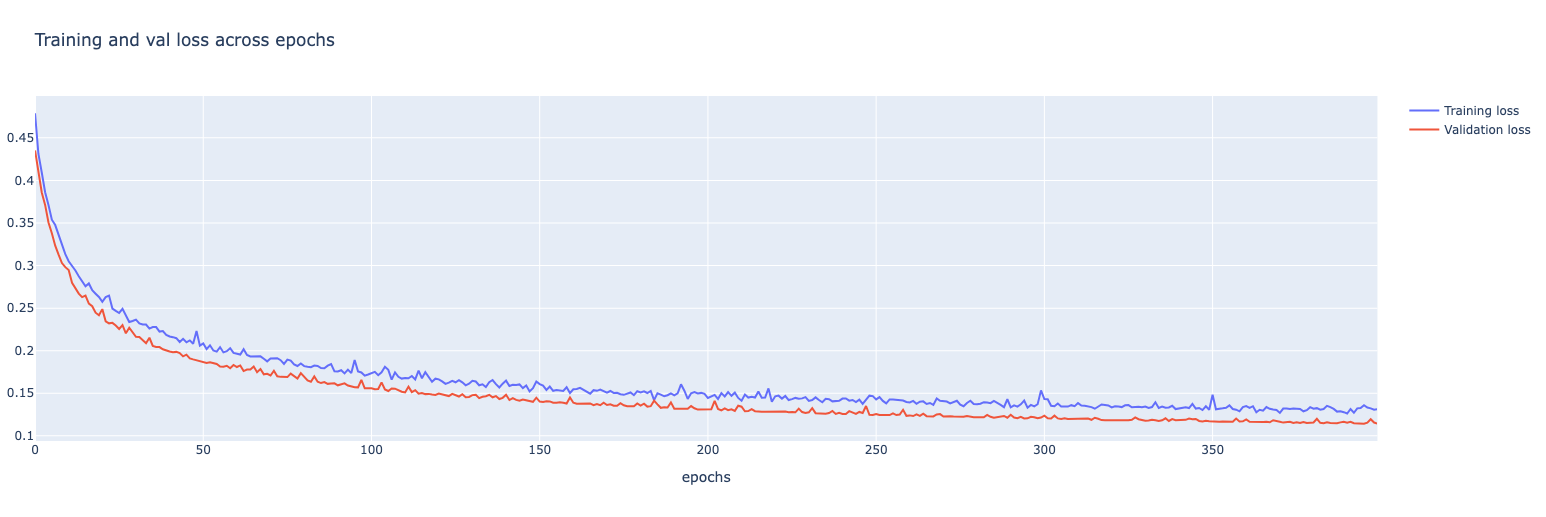

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["f1"],
                          name="Training F1",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_f1"],
                          name="Validation F1",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val F1 across epochs',
    xaxis_title='epochs',
    yaxis_title='F1'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
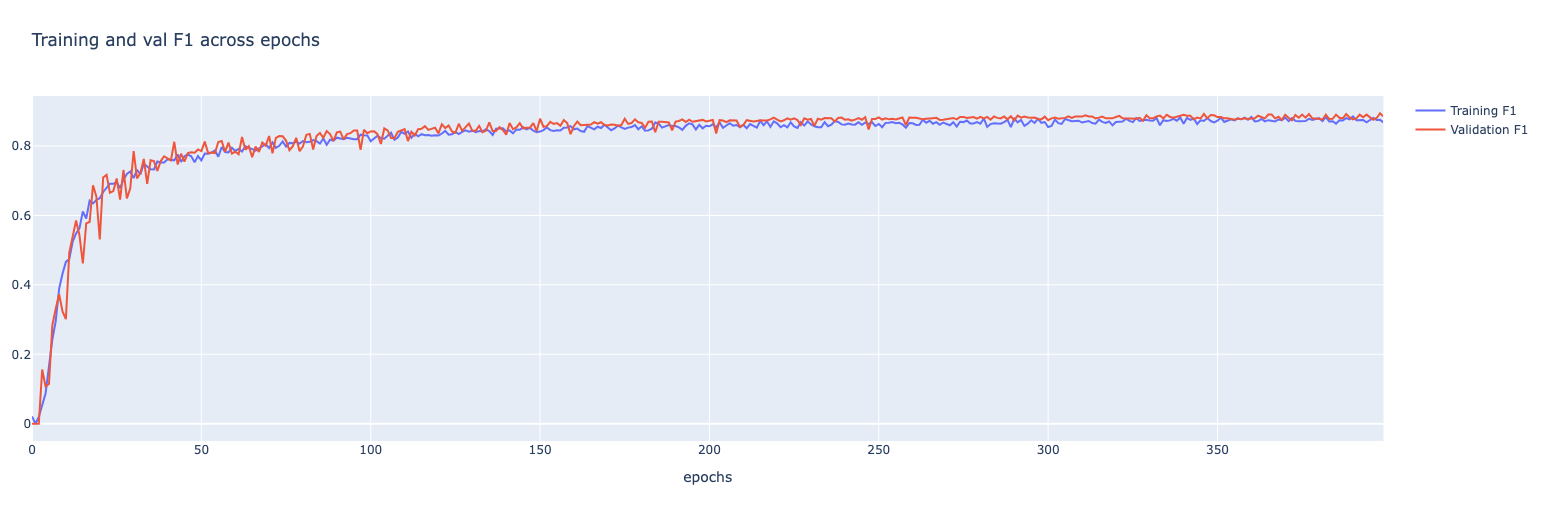

### A higher number of trainable parameters:

In [3]:
model = BertModel.from_pretrained("bert-base-multilingual-uncased")
num_children = 0
for child in model.children():
    num_children += 1
    print(num_children)
    print(child)

1
BertEmbeddings(
  (word_embeddings): Embedding(105879, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
2
BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dens

Not many children: I don't have the opportunity to be granular in my fine-tuning. Let's see if I can access parameters directly:

In [ ]:
model.parameters

<bound method Module.parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(105879, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
)>

In [4]:
model = BertModel.from_pretrained("bert-base-multilingual-uncased")

num_params = 0
for param in model.parameters(recurse=True):
    num_params += 1
print("Number of parameters before adding to model.pooler: ", num_params)

for param in model.parameters():
    param.requires_grad = False

model.pooler = nn.Sequential(
    model.pooler,
    nn.Linear(in_features=model.pooler.dense.out_features,
              out_features=1),
    nn.Sigmoid()
)

num_params = 0
for param in model.parameters(recurse=True):
    num_params += 1
print("number of parameters after adding to model.pooler: ", num_params)

fine_tune_at = num_params - 30
for param in list(model.parameters(recurse=True))[fine_tune_at:]:
    param.requires_grad = True

Number of parameters before adding to model.pooler:  199
number of parameters after adding to model.pooler:  201


In [10]:
num_params = 0
for param in model.parameters(recurse=True):
    if param.requires_grad == True:
        num_params += 1
print(num_params)

30


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, criterion = model.to(device), criterion.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'f1': [], 'val_f1': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode

        # Training loop
        total_loss= 0
        all_train_outputs = []
        all_train_labels = []
        for inputs, labels in train_loader:
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            all_train_outputs.append(outputs.detach().cpu()) # makes sure the concatenation is done on the same device, even if the tensors were in different devices
            all_train_labels.append(labels.detach().cpu())


        # Compute average loss and F1 score for training
        train_loss = total_loss / len(train_loader)
        train_f1 = binary_f1_score(torch.cat(all_train_outputs),
                                   torch.cat(all_train_labels),
                                   threshold=0.5)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        all_val_outputs = []
        all_val_labels = []
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                all_val_outputs.append(outputs.detach().cpu()) # makes sure the concatenation is done on the same device, even if the tensors were in different devices
                all_val_labels.append(labels.detach().cpu())


        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_f1 = binary_f1_score(torch.cat(all_val_outputs),
                                 torch.cat(all_val_labels),
                                 threshold=0.5)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=100)

Epoch [1/100], Loss: 0.2686, F1: 0.6770, Val Loss: 0.1282, Val F1: 0.8884
Epoch [2/100], Loss: 0.1883, F1: 0.8283, Val Loss: 0.1356, Val F1: 0.8811
Epoch [3/100], Loss: 0.1301, F1: 0.8799, Val Loss: 0.1118, Val F1: 0.8874
Epoch [4/100], Loss: 0.1489, F1: 0.8585, Val Loss: 0.2006, Val F1: 0.8066
Epoch [5/100], Loss: 0.1554, F1: 0.8558, Val Loss: 0.0978, Val F1: 0.9103
Epoch [6/100], Loss: 0.1252, F1: 0.8881, Val Loss: 0.1331, Val F1: 0.8735
Epoch [7/100], Loss: 0.1319, F1: 0.8600, Val Loss: 0.1728, Val F1: 0.7766
Epoch [8/100], Loss: 0.1581, F1: 0.8662, Val Loss: 0.1150, Val F1: 0.9084
Epoch [9/100], Loss: 0.1189, F1: 0.8897, Val Loss: 0.0878, Val F1: 0.9289
Epoch [10/100], Loss: 0.1609, F1: 0.8680, Val Loss: 0.1407, Val F1: 0.8898
Epoch [11/100], Loss: 0.1210, F1: 0.8908, Val Loss: 0.1204, Val F1: 0.8938
Epoch [12/100], Loss: 0.1028, F1: 0.9055, Val Loss: 0.0955, Val F1: 0.9095
Epoch [13/100], Loss: 0.1041, F1: 0.9007, Val Loss: 0.1037, Val F1: 0.9068
Epoch [14/100], Loss: 0.0956, F1: 

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Binary Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
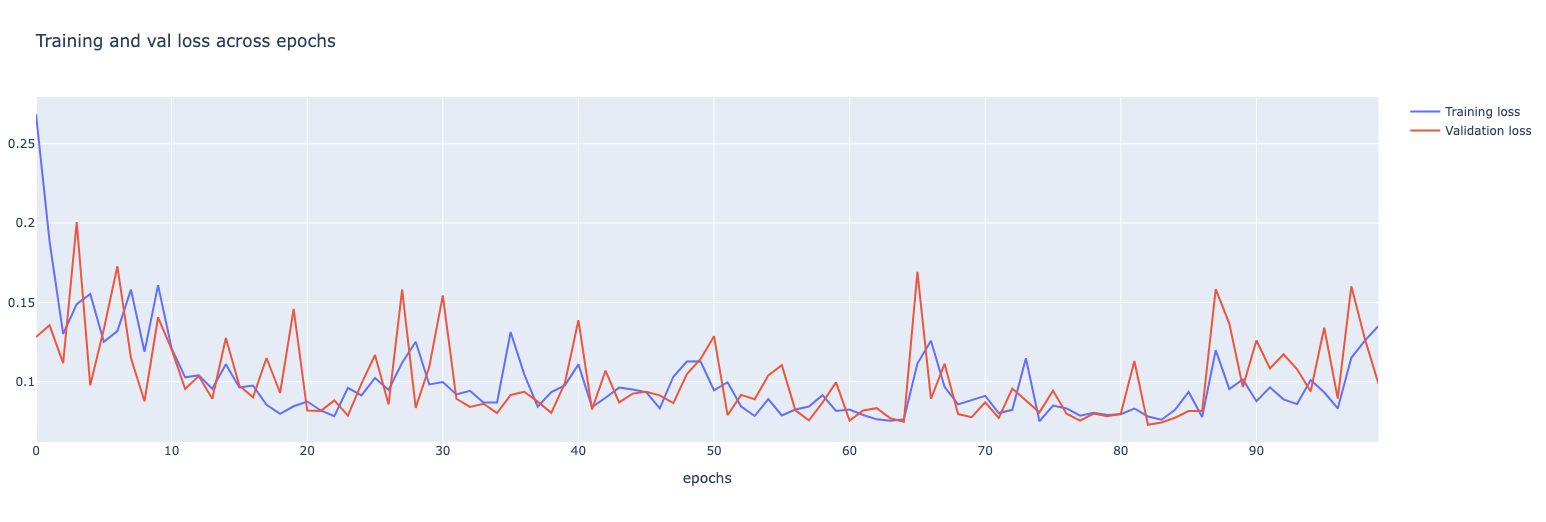

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["f1"],
                          name="Training F1",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_f1"],
                          name="Validation F1",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val F1 across epochs',
    xaxis_title='epochs',
    yaxis_title='F1'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
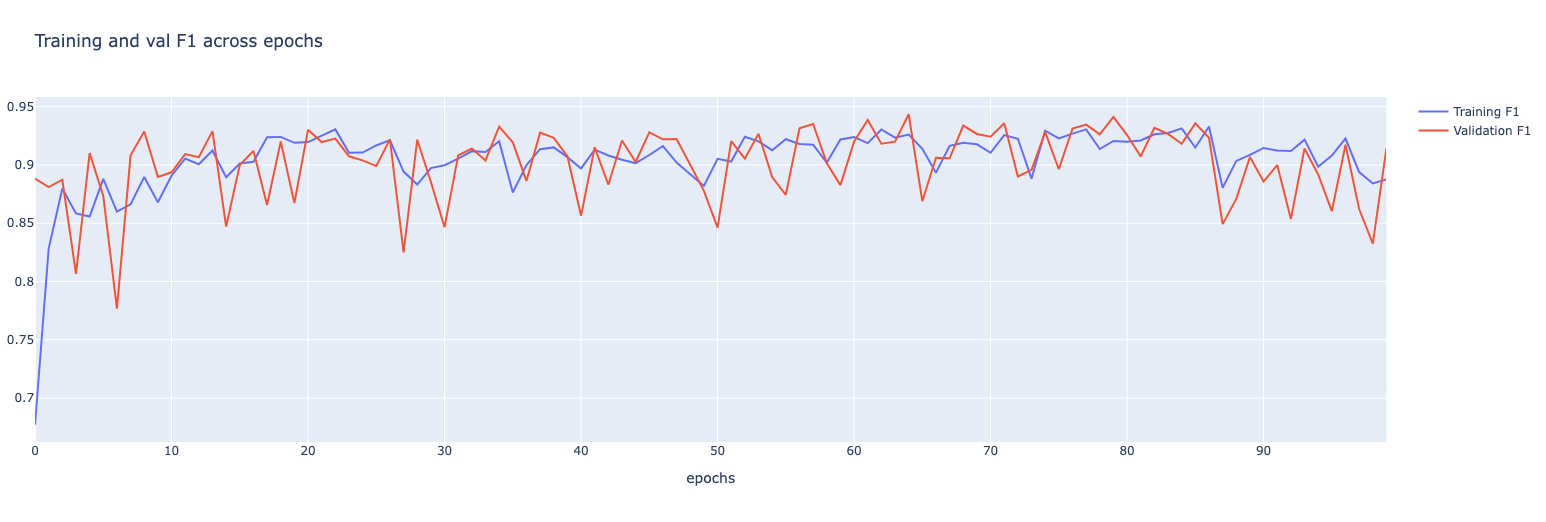

### Smaller Adam learning rate:

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model, criterion = model.to(device), criterion.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'f1': [], 'val_f1': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode

        # Training loop
        total_loss = 0
        all_train_outputs = []
        all_train_labels = []
        for inputs, labels in train_loader:
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            all_train_outputs.append(outputs.detach().cpu()) # Move to CPU for concatenation
            all_train_labels.append(labels.detach().cpu()) # Move to CPU for concatenation


        # Compute average loss and F1 score for training
        train_loss = total_loss / len(train_loader)
        train_f1 = binary_f1_score(torch.cat(all_train_outputs),
                                   torch.cat(all_train_labels),
                                   threshold=0.5)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        all_val_outputs = []
        all_val_labels = []
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                all_val_outputs.append(outputs.detach().cpu()) # Move to CPU for concatenation
                all_val_labels.append(labels.detach().cpu()) # Move to CPU for concatenation


        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_f1 = binary_f1_score(torch.cat(all_val_outputs),
                                 torch.cat(all_val_labels),
                                 threshold=0.5)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=100)

Epoch [1/100], Loss: 0.1572, F1: 0.8178, Val Loss: 0.0909, Val F1: 0.9237
Epoch [2/100], Loss: 0.0779, F1: 0.9294, Val Loss: 0.0748, Val F1: 0.9342
Epoch [3/100], Loss: 0.0515, F1: 0.9512, Val Loss: 0.0767, Val F1: 0.9221
Epoch [4/100], Loss: 0.0395, F1: 0.9645, Val Loss: 0.0638, Val F1: 0.9407
Epoch [5/100], Loss: 0.0231, F1: 0.9783, Val Loss: 0.0586, Val F1: 0.9409
Epoch [6/100], Loss: 0.0250, F1: 0.9763, Val Loss: 0.0776, Val F1: 0.9507
Epoch [7/100], Loss: 0.0204, F1: 0.9808, Val Loss: 0.1355, Val F1: 0.8808
Epoch [8/100], Loss: 0.0128, F1: 0.9865, Val Loss: 0.0963, Val F1: 0.9489
Epoch [9/100], Loss: 0.0074, F1: 0.9935, Val Loss: 0.1112, Val F1: 0.9290
Epoch [10/100], Loss: 0.0144, F1: 0.9845, Val Loss: 0.0854, Val F1: 0.9417
Epoch [11/100], Loss: 0.0074, F1: 0.9920, Val Loss: 0.1128, Val F1: 0.9422
Epoch [12/100], Loss: 0.0049, F1: 0.9945, Val Loss: 0.2215, Val F1: 0.9152
Epoch [13/100], Loss: 0.0215, F1: 0.9839, Val Loss: 0.1227, Val F1: 0.9399
Epoch [14/100], Loss: 0.0083, F1: 

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Binary Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
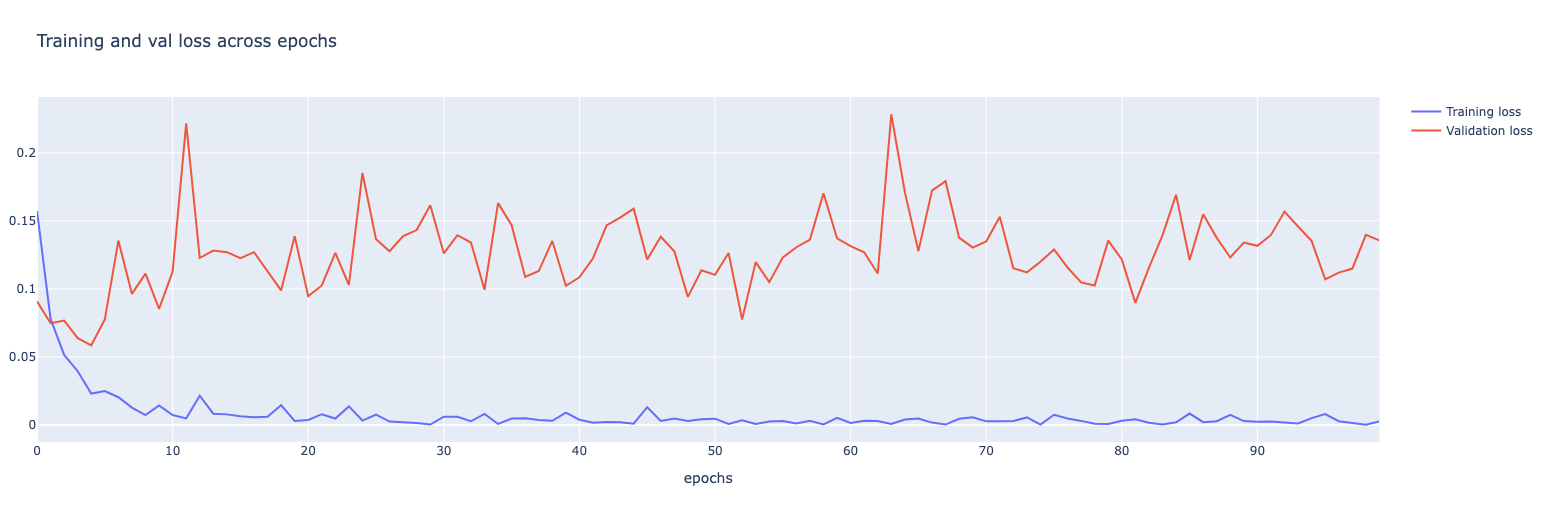

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["f1"],
                          name="Training F1",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_f1"],
                          name="Validation F1",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val F1 across epochs',
    xaxis_title='epochs',
    yaxis_title='F1'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
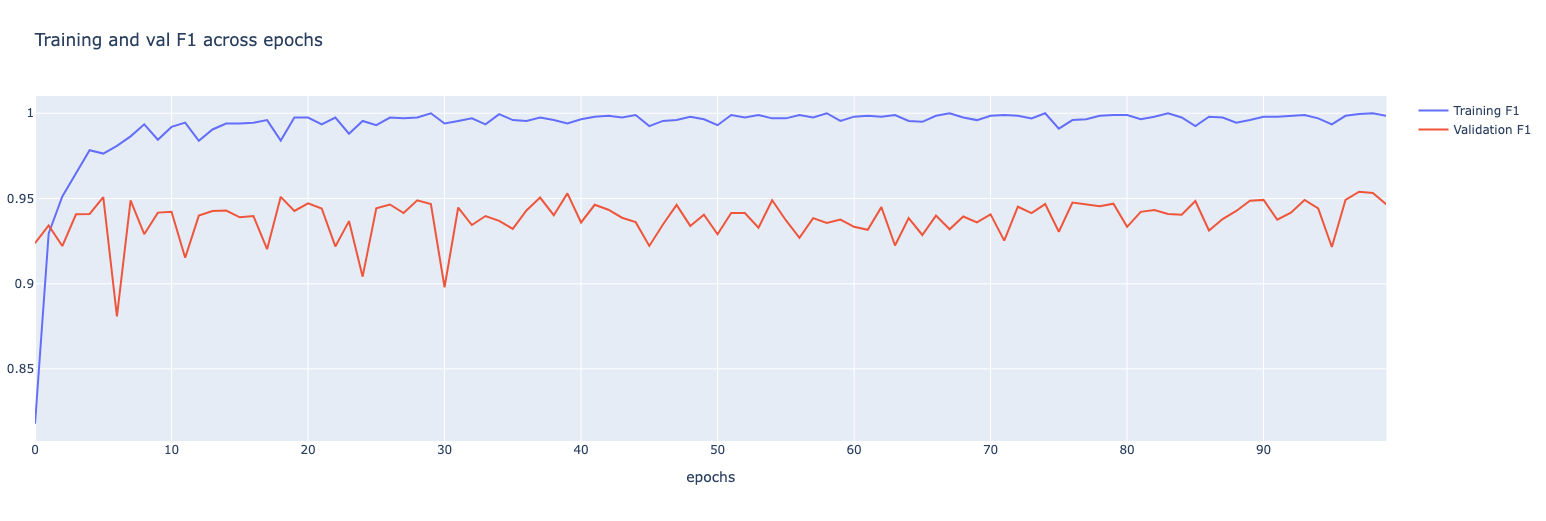

### Less small Adam steps

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
model, criterion = model.to(device), criterion.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'f1': [], 'val_f1': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode

        # Training loop
        total_loss = 0
        all_train_outputs = []
        all_train_labels = []
        for inputs, labels in train_loader:
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            all_train_outputs.append(outputs.detach().cpu()) # Move to CPU for concatenation
            all_train_labels.append(labels.detach().cpu()) # Move to CPU for concatenation


        # Compute average loss and F1 score for training
        train_loss = total_loss / len(train_loader)
        train_f1 = binary_f1_score(torch.cat(all_train_outputs),
                                   torch.cat(all_train_labels),
                                   threshold=0.5)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        all_val_outputs = []
        all_val_labels = []
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs).pooler_output.squeeze()  # Forward pass, access pooler_output
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                all_val_outputs.append(outputs.detach().cpu()) # Move to CPU for concatenation
                all_val_labels.append(labels.detach().cpu()) # Move to CPU for concatenation


        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_f1 = binary_f1_score(torch.cat(all_val_outputs),
                                 torch.cat(all_val_labels),
                                 threshold=0.5)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=400)

Epoch [1/400], Loss: 0.3413, F1: 0.3226, Val Loss: 0.3067, Val F1: 0.2400
Epoch [2/400], Loss: 0.2945, F1: 0.5317, Val Loss: 0.2659, Val F1: 0.7143
Epoch [3/400], Loss: 0.2738, F1: 0.6127, Val Loss: 0.2621, Val F1: 0.4768
Epoch [4/400], Loss: 0.2567, F1: 0.6618, Val Loss: 0.2460, Val F1: 0.5932
Epoch [5/400], Loss: 0.2434, F1: 0.6921, Val Loss: 0.2403, Val F1: 0.6205
Epoch [6/400], Loss: 0.2380, F1: 0.7086, Val Loss: 0.2516, Val F1: 0.5698
Epoch [7/400], Loss: 0.2230, F1: 0.7394, Val Loss: 0.2323, Val F1: 0.6411
Epoch [8/400], Loss: 0.2214, F1: 0.7499, Val Loss: 0.2047, Val F1: 0.7458
Epoch [9/400], Loss: 0.2128, F1: 0.7541, Val Loss: 0.1977, Val F1: 0.8017
Epoch [10/400], Loss: 0.2123, F1: 0.7751, Val Loss: 0.2065, Val F1: 0.8008
Epoch [11/400], Loss: 0.2106, F1: 0.7631, Val Loss: 0.1874, Val F1: 0.8037
Epoch [12/400], Loss: 0.2031, F1: 0.7874, Val Loss: 0.1886, Val F1: 0.7780
Epoch [13/400], Loss: 0.2005, F1: 0.7816, Val Loss: 0.1914, Val F1: 0.7624
Epoch [14/400], Loss: 0.1960, F1: 

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Binary Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
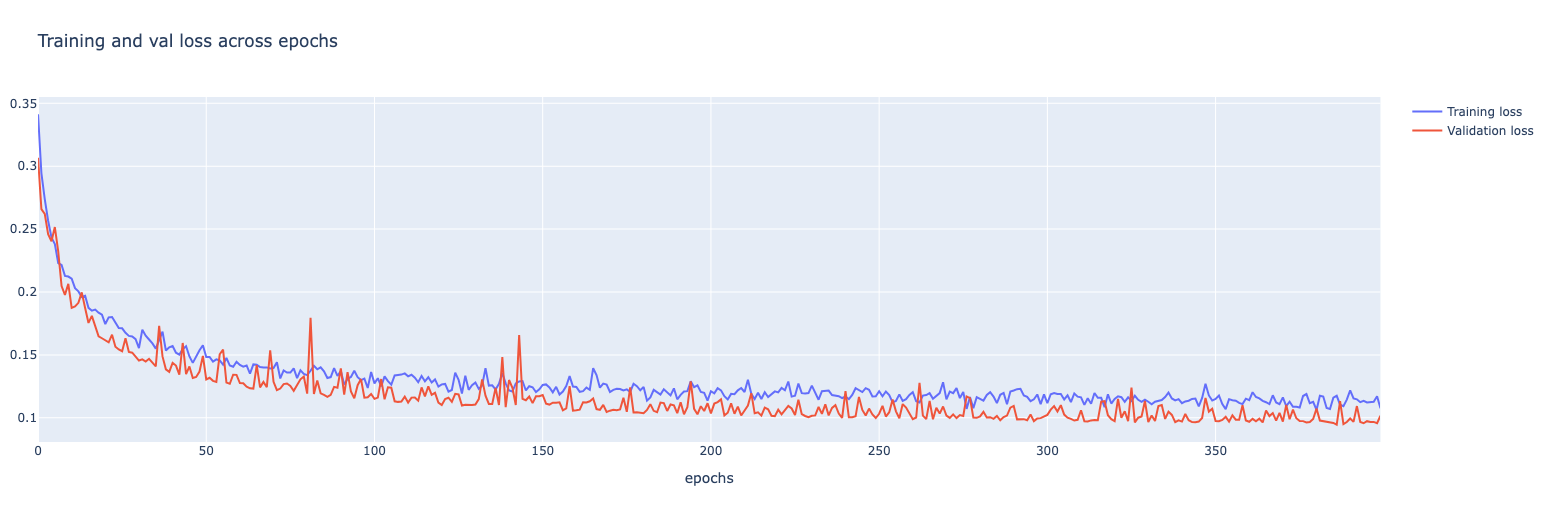

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["f1"],
                          name="Training F1",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_f1"],
                          name="Validation F1",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val F1 across epochs',
    xaxis_title='epochs',
    yaxis_title='F1'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
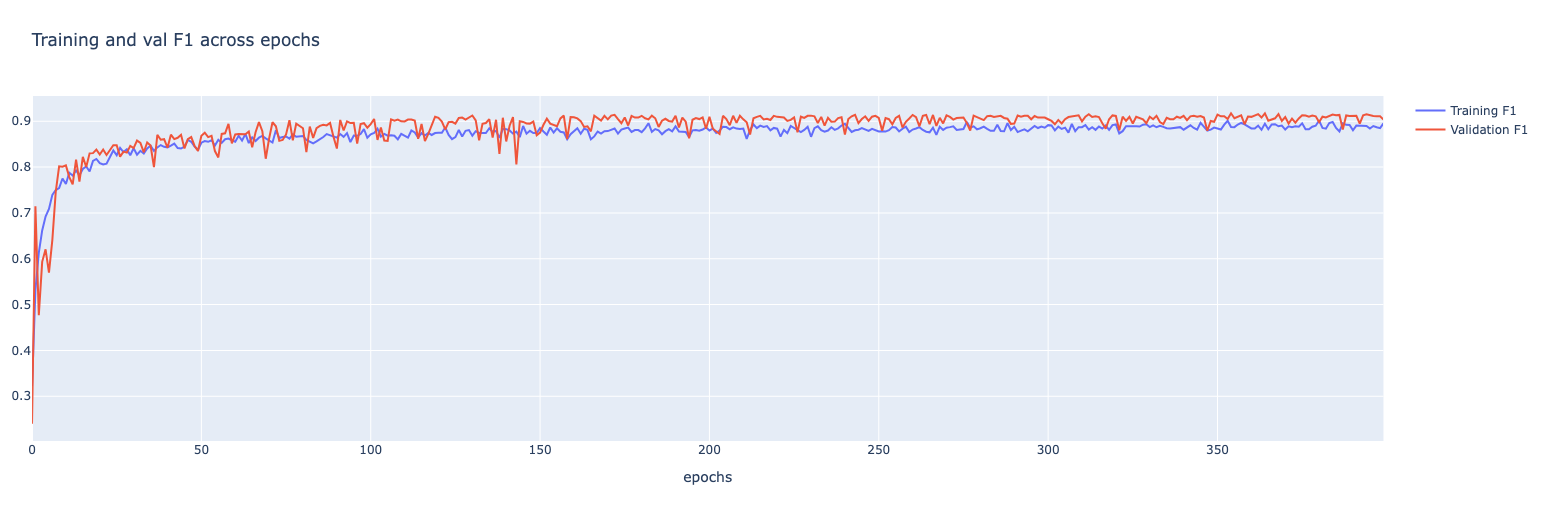